In [1]:
# Python notebook to study the effects of improper BBoxes fed to NEMO classifier

import time, os, sys, warnings
import os.path as osp
import numpy as np
import sklearn

%matplotlib inline
from pylab import *
import pydot
import matplotlib.patches as patches

import caffe
import pynemo
from PIL import ImageDraw, Image
import csv
from caffe import layers as L, params as P
from caffe.proto import caffe_pb2
import caffe.draw

from IPython.display import Image, display

import cv2
from PIL import Image
# from easydict import EasyDict as edict
# from easydict import EasyDict

caffe.set_device(1)
caffe.set_mode_gpu()

In [2]:
# get the data loader here

# Helper functions for loading data

def get_cord(txt_loc):
    cord = []
    with open(txt_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')		
        cord_arr = np.zeros(4) 
        for row in reader:
            """
            The below stuff is required if the a$$nuckle who created the bboxes txt file didn't tab delimit 
            but instead used spaces
            """
            if (len(row) == 1):
                row = row[0].split()
            img_class = row[0]
            cord.append(row[0])
            cord_arr[0] = float(row[4])
            cord_arr[1] = float(row[5])
            cord_arr[2] = float(row[6])
            cord_arr[3] = float(row[7])
            cord.append(cord_arr)
            cord_arr = np.zeros(4)
    f.close()
    return cord

def data_loader(path, mode, return_img = False):
    """
    Function to load image locations, corresponding classes and BBoxes contained withing a list file

    return:
    A list with each individual image of the form
    [Image_location in str, Image_Class, BBox in []]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + mode + '.list'
    data = [] 
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')		
        for row in reader:
            # seperate test-case for COCO
            if (path[-5:-1] == 'COCO'):   
                text = row[0][0:5] + '-labels/' + row[0][-16:-3] + 'txt'
            # for VOC and GVDL-D
            else:
                if (mode == 'test'):
                    text = row[0][0:5] + 'labels'+ row[0][11:-3] + 'txt' 
                if (mode == 'validation'):
#                     print(row[0])
#                     print(row[0][0:11]+ 'labels'+ row[0][15:-3])
                    text = row[0][0:11] + 'labels'+ row[0][17:-3] + 'txt' 
                if (mode == 'train'):
#                     print(row[0])
#                     print(row[0][0:6]+ 'labels'+ row[0][12:-3])
                    text = row[0][0:6] + 'labels' + row[0][12:-3] + 'txt'
            cord = get_cord(path + text)
#             print(cord[1])
            img = Image.open(path + row[0])
            if (len(np.shape(img))!=3):
                img = np.asarray(img)
                img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
#             print(np.shape(img))
            cord[1] = normalized_cord(img,cord[1])
#             print(cord[1])
            if (return_img == False):
                data.append([path + row[0], cord])
            else:
#                 print("Demanding images")
                data.append([Image.open(path + row[0]), cord])
                
    """ The following code is to verify the dataloader 
        Please give the index of the image file you want to load; the code will take care of the txt file
        To verify, give a particular index
    """
#     print(len(data))
    return data

def normalized_cord(image, cord):
#     function to normalize the cordinates
    y, x,_ = np.shape(image)
    x_top, y_top, x_bottom, y_bottom = cord
    return x_top/x, y_top/y, x_bottom/x, y_bottom/y

In [3]:
# To load the GVDL data
data_train = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/GVDL-D/', 'train', return_img = False)
data_test = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/GVDL-D/', 'validation', return_img = False)
# data_valid = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/GVDL-D/', 'validation', return_img = False)

In [4]:
def loadBatch(net, processed_ims):
    
    num_images = len(processed_ims)
    max_shape = np.array([im.shape for im in processed_ims]).max(axis=0)
    
    # Blob placeholder
    blob = np.zeros((num_images, max_shape[0], max_shape[1], 3),dtype=np.float32)

    
    # load images into blob placeholder
    #==================================================
    for i in range(num_images):
        im = processed_ims[i]
#         print(i)
        blob[i, 0:im.shape[0], 0:im.shape[1], :] = im
    

    # Change Channels in Caffe format
    #==================================================
    channel_swap = (0, 3, 1, 2)   # Original    
    blob = blob.transpose(channel_swap)


#     im_scales = np.array(im_scale_factors)

    blobs = {'data' : None}
    blobs['data'] = blob
    im_blob = blobs['data']
    # reshape network inputs
    net.blobs['data'].reshape(*(blobs['data'].shape))
    return {'data': blobs['data'].astype(np.float32, copy=False)}

In [5]:
def forward(img, cord):
#     print(cord)
    net =  caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-512.prototxt',
                     '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-512.caffemodel',
                     caffe.TEST)
    blobs_out = net.forward(**loadBatch(net,[img]))
#     print(np.shape(img))
#     out = loadBatch(net,img)
    mydata = net.blobs['cascade192/output'].data
#     index = 0
#     output = np.squeeze(mydata[0,index,:,:])
#     plt.imshow(output)
    
    
#     must get the labels ready
#     print(np.shape(mydata.tolist()))
#     print(np.shape(cord))
    cord = np.reshape(cord,(1,1,1,5))

#     print(np.shape(cord))
    net3 = caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/complete_model_gorchnet.prototxt',
                     '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-ROI.caffemodel',
                    caffe.TEST)
    net3.blobs['data'].data[...] = mydata.tolist()
    net3.blobs['bboxes'].data[...] = cord.tolist()
    class_output = net3.forward()
    out =  net3.blobs['global_pool'].data
    roi = net3.blobs['roi_pool'].data
#     print(np.shape(net3.blobs['roi_pool'].data[...]))
#     print(np.shape(out))
    return out

In [6]:
# Following fucntion comes with Image visualization; for main purpose use the scale_cord function
def update_cord(cord_arr,scale = 1):
    #  function to display the image being passed to the network 
    x_top, y_top, x_bottom, y_bottom = cord_arr[1:]
    img_dim = 1
    center = np.array([(x_top + x_bottom)/2, (y_top + y_bottom)/2])
    dims = np.array([x_bottom-center[0],y_bottom-center[1]])
    x_center, y_center = center[0], center[1]
    x_top = x_center-dims[0]*scale
    if (x_top < 0):
        x_top = 0
    y_top = y_center-dims[1]*scale
    if (y_top < 0):
        y_top = 0
    x_bottom = x_center+dims[0]*scale
    if (x_bottom > img_dim):
        x_bottom = img_dim
    y_bottom = y_center+dims[1]*scale
    if (y_bottom > img_dim):
        y_bottom = img_dim
    new_cord = np.array([0,x_top/img_dim, y_top/img_dim, x_bottom/img_dim, y_bottom/img_dim])
    return new_cord

In [286]:
def display_img(img, cord_arr,scale = 1, color = (255,0,0)):
#     function to display the image being passed to the network 
    cord_arr = update_cord(cord_arr, scale)
    x_top, y_top, x_bottom, y_bottom = cord_arr[1:]
    x_top, y_top, x_bottom, y_bottom = int(x_top*512), int(y_top*512), int(x_bottom*512), int(y_bottom*512) 
    center = np.array([(x_top + x_bottom)/2, (y_top + y_bottom)/2])
    dims = np.array([x_bottom-center[0],y_bottom-center[1]])
    x_center, y_center = int(center[0]), int(center[1])
#     print("The center of the BBox",x_center, y_center)
#     print("The dimensions are ", dims/2)
#     print("The original cordinates of the BBox",x_top, y_top, x_bottom, y_bottom)
    x_top = int(abs(x_center-dims[0]))
    y_top = int(abs(y_center-dims[1]))
    x_bottom = int(abs(x_center+dims[0]))
    y_bottom = int(abs(y_center+dims[1]))
#     print("The new cordinates of the BBox",x_top, y_top, x_bottom, y_bottom)
    cv2.rectangle(img,(x_top,y_top),(x_bottom,y_bottom),(0,255,0),3)
#     x_top, y_top, x_bottom, y_bottom = x_top * scale, y_top * scale, x_bottom * scale, y_bottom * scale 
    x_top = int(x_center-dims[0]*scale)
#     print(x_center, x_top)
    if (x_top < 0):
        x_top = 0
    y_top = int(y_center-dims[1]*scale)
    if (y_top < 0):
        y_top = 0
    x_bottom = int(x_center+dims[0]*scale)
    if (x_bottom > 512):
        x_bottom = 512
    y_bottom = int(y_center+dims[1]*scale)
    if (y_bottom > 512):
        y_bottom = 512
#     print("The cordinates of the BBox",x_top, y_top, x_bottom, y_bottom)
    cv2.rectangle(img,(int(x_top),int(y_top)),(int(x_bottom),int(y_bottom)),color,3)
    fig7,ax7 = plt.subplots(1)
    ax7.imshow(img)
    new_cord = np.array([0,x_top, y_top, x_bottom, y_bottom])
#     plt.imshow(img)
    return new_cord.tolist()

In [8]:
def process_data(data):
    print(len(data))
    img_list = []
    gt_label_list = []
    gt_cord_list = []
    pad = np.zeros((len(data),1))
    for i in range(len(data)):
        img_list.append(data[i][0])
        gt_label_list.append(data[i][1][0])
        gt_cord_list.append(data[i][1][1])
    # print(gt_cord_list)
    gt_cord_arr = np.asarray(gt_cord_list)
    gt_cord_arr = np.hstack((pad, gt_cord_arr))
#     print(gt_cord_arr[0])
    im_batch = img_list   # Pass the batch
    num_images = len(im_batch)
    processed_ims = []
    im_scale_factors = []  #for multiscale processing

    for j,im_file  in enumerate(im_batch):
    #     print(im_file)
        im = cv2.imread(im_file)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
#         plt.imshow(im)

        # Retype and normilize image
        #-------------------------------------------
        im_orig = im.astype(np.float32, copy=True)
        im_orig /= 255
        im_orig -= .5


        # Get shape and Max and Min of an image
        #-------------------------------------------
        im_shape = im_orig.shape
    #     print(im_shape)
        im_size_min = np.min(im_shape[0:2])
        im_size_max = np.max(im_shape[0:2])


        target_size = 512
        im_scale = float(target_size) / float(im_size_min)

        #--------------------------------------------------------------
        # Future: multiscale load
        # Prevent the biggest axis from being more than MAX_SIZE
        #if np.round(im_scale * im_size_max) > MAX_SIZE:
        #    im_scale = float(MAX_SIZE) / float(im_size_max)
        #--------------------------------------------------------------
        imW = (im_shape[1])
        imH = (im_shape[0])

        target_size = 512
        im_scaleX = float(target_size) / float(imW)
        im_scaleY = float(target_size) / float(imH)

        im = cv2.resize(im_orig, None, None, fx=im_scaleX, fy=im_scaleY, interpolation=cv2.INTER_LINEAR)

    #     im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR)
    #     print(im.shape)

        im_scale_factors.append(im_scale)

        processed_ims.append(im)
#     print(np.shape(processed_ims))
    return processed_ims, gt_cord_arr, gt_label_list

In [9]:
# Below is the code for translation
processed_ims, gt_cord_arr, gt_label_list = process_data(data_train)
processed_ims2, gt_cord_arr2, gt_label_list2 = process_data(data_test)

131
159


In [26]:
# xmin ymin xmax ymax
def IOUCalc(boxes, query_boxes):
    """
    determine overlaps between boxes and query_boxes
    :param boxes: n * 5 bounding boxes (4 + 1 for objectness)
    :param query_boxes: k * 5 bounding boxes (4 + 1 for objectness)
    :return: overlaps: n * k overlaps
    """
    #overlaps = np.zeros((n_, k_), dtype=np.float)
    #for k in range(k_):
    query_box_area = (query_boxes[3] - query_boxes[1] + 1) * (query_boxes[4] - query_boxes[2] + 1)
    #for n in range(n_):
    iw = min(boxes[3], query_boxes[3]) - max(boxes[1], query_boxes[1]) + 1
    if iw < 0:
        return 0
    if iw > 0:
        ih = min(boxes[4], query_boxes[4]) - max(boxes[2], query_boxes[2]) + 1
        if ih < 0:
            return 0
        if ih > 0:
            box_area = (boxes[3] - boxes[1] + 1) * (boxes[4] - boxes[2] + 1)
            all_area = float(box_area + query_box_area - iw * ih)
            overlaps = iw * ih / all_area
        return overlaps

In [21]:
def evaluate(test_vec):
    predictions = nemo.predict_proba(test_vec, omit_nothing = False)
#     print(predictions)
    preds = predictions.idxmax(axis=1)
    pred_class = [preds[i] for i in range (len(preds))]
    return pred_class

In [246]:
def translate(img_test, cord_test):
    shape,_,_ = np.shape(img_test) 
    x_top, y_top, x_bottom, y_bottom = cord_test[1:]-0.2
    # print(cord_test[1:], cord_test[1:] - 0.2)
    update_list = []
    up_scale = 0.8
    down_scale = 0.02
    for i in range (0,int(up_scale/down_scale)):#0,0.4,0.02
        for j in range (0,int(up_scale/down_scale)):
            top_x = x_top + i / (1/down_scale)
            top_y = y_top + j / (1/down_scale)
            bottom_x = x_bottom + i / (1/down_scale)
            bottom_y = y_bottom + j / (1/down_scale)
            if (top_x < 0):
                top_x = 0
            if (top_y < 0):
                top_y = 0
            if (bottom_x > 1):
                bottom_x = 1
            if (bottom_y > 1): 
                bottom_y = 1
#             print((bottom_x - top_x)* (bottom_y - top_y))
#             cv2.rectangle(img_test,(int(top_x*512),int(top_y*512)),(int(bottom_x*512),int(bottom_y*512)),(255,0,0),3)
            update_list.append(np.array([0,top_x, top_y, bottom_x, bottom_y]))
#             fig1,ax1 = plt.subplots(1)
#             ax1.imshow(img_test)
    plt.imshow(img_test)
    update_arr = np.asarray(update_list)
    overlap = np.zeros([len(update_arr)])
    for i in range(len(update_arr)):
        overlap[i] = int(IOUCalc(cord_test*512, update_arr[i]*512)*100)
    return overlap, update_arr

def plot_hist(overlap):
    fig,ax = plt.subplots(1)
    ax.hist(overlap)
    plt.xlabel('Itersection Over Union (IoU)')
    plt.ylabel('Number of Boxes')
#     plt.title('Distribution of Boxes')

In [247]:
def Class_IOU(img_test, cord_test, gt_test, up_value, num_boxes = 1):
#     print("The true label is ", gt_test)
    overlap, update_arr = translate(img_test, cord_test)
    
    interval = np.arange(-5,105,5)
    
    for i in range(len(overlap)):
        flag = False
        k = 0
        while(flag == False):
            if (interval[k] <= overlap[i] <= interval[k+1]):
                flag = True
                overlap[i] = interval[k+1]
                continue 	
            k = k + 1 
    
    arr = np.zeros((update_arr.shape[0], update_arr.shape[1]+1))
    arr[:,1:] = update_arr
    arr[:,0] = overlap
#     print(arr)

    sol = np.where(arr[:,0] == up_value)
    sol_arr = np.zeros((len(sol[0]),arr.shape[1]))
#     print(sol[0])
#     print(len(sol))
#     print(np.shape(sol))
#     print(np.shape(sol_arr))
    
    for i in range(len(sol[0])):
        sol_arr[i,:] = arr[sol[0][i]]
#     print(sol_arr)
    np.random.shuffle(sol_arr)
#     print(sol_arr)
    
    ans = []
    for i in range(num_boxes):
        ans.append(sol_arr[i][1:])
    ans = np.asarray(ans)
    return ans
#     print(ans)
#     print(np.shape(arr))
    
#     arr = np.concatenate((update_arr, overlap.T))
#     for z in overlap:
#         for i in range(len(z)):		# This loop contains all the elements: 159 elements in total
#             for j in range(len(z[i])): 		# This loop over individual elements:
#                 flag = False
#                 k = 0
#                 while(flag == False):
#                     if (interval[k] <= z[i][j][0] <= interval[k+1]):
#                         flag = True
#                         z[i][j][0] = interval[k+1]
#                         continue 	
#                     k = k + 1 
    """
    overlap = get_IOU(cord_test, update_arr)
#     print("passed")
    plot_hist(overlap)
    # for testing
    input_vec_test = []
    for i in range(len(update_arr)):
        # Forward Pass for classification
        out = forward(img_test, update_arr[i])
        input_vec_test.append(np.reshape(out,(128)))
    # Predicition results
    pred = evaluate(input_vec_test)
    TP = []
    FP = []
    NIK = []
    for i in range(len(overlap)):
    #   print(pred[i], overlap[i], gt_test)
    #   print(pred[i])
        if (pred[i] == gt_test):
            TP.append(overlap[i])
        elif (pred[i] == "Nothing I know"):
            NIK.append(overlap[i])
        else:
            FP.append(overlap[i])
    unique_IOU = list(set(overlap)) 
#     print(unique_IOU)
    unique_IOU = sorted(unique_IOU) 
    TP = {x:TP.count(x) for x in sorted(unique_IOU)}  
    FP = {x:FP.count(x) for x in sorted(unique_IOU)}  
    NIK = {x:NIK.count(x) for x in sorted(unique_IOU)}  
    
#     print(unique_IOU)
#     print(TP)
#     print(FP)
#     print(NIK)
    

    TP = list(TP.values())
    FP = list(FP.values())
    NIK = list(NIK.values())

    # Save the final answer in [IoU, TP, FP, NIK]
    distribution = np.zeros([len(unique_IOU),4])

    for i in range(len(unique_IOU)):
        distribution[i,:] = unique_IOU[i], TP[i], FP[i], NIK[i]  
    return distribution
    """

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.      0.02667 0.0218  0.97556 0.97548]]
Hi


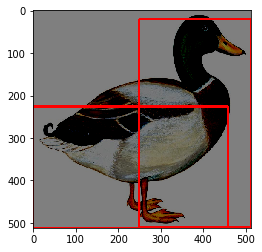

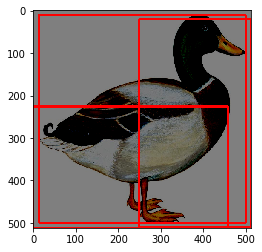

In [303]:
index = 1 #change the image here
test_cord = Class_IOU(processed_ims[index],  gt_cord_arr[index],  gt_label_list[index], up_value = 100, num_boxes = 1)
print(test_cord)
print("Hi")
color = (0,255,255)
for i in range(len(test_cord)):
    display_img(processed_ims[index], test_cord[i])